# Search inside astroquery catalog


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : 2023/05/17
- last update : 
- FORS2 : https://github.com/ericnuss/fors2
- Result of StarLight : /sps/lsst/groups/photoz/fors2/FORS2/ResStarlight



          /Users/dagoret/MacOSX/GitHub/LSST/FORS2>ls -l
              total 0
              drwxrwsr-x  3 dagoret  staff   96 Aug 21  2018 ResStarlight
              drwxr-xr-x  9 dagoret  staff  288 Dec 19 18:01 fors2

https://astroquery.readthedocs.io/en/latest/

## Import

In [1]:
import os,sys,re
import h5py
from astropy.table import Table
import random

from astropy import coordinates
from astropy import units as u
from astropy.coordinates import Angle
from astroquery.skyview import SkyViewClass
from astroquery.skyview import *
# https://astroquery.readthedocs.io/en/latest/api/astroquery.skyview.SkyViewClass.html

from astropy.wcs import WCS

from astroquery.sdss.core import SDSS
from astropy import coordinates as coords

In [2]:
# Import some generally useful packages

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
import pandas as pd
from itertools import cycle, islice


In [3]:
from scipy import ndimage

#from scipy import interp as scinterp
from scipy.interpolate import interp1d

import glob
import collections
#from def_raw_seds import *

In [4]:
# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [5]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [6]:
def GetColumnHfData(hff,list_of_keys,nameval):
    """
    Extract hff atttribute 
    
    parameters
      hff           : descriptor of h5 file
      list_of_keys : list of exposures
      nameval      : name of the attribute
      
    return
           the array of values in the order of 
    """
    

    all_data = []
    for key in list_of_keys:
        group=hff.get(key)
        val=group.attrs[nameval]
        all_data.append(val)
    return all_data


In [7]:
def ReadFors2h5FileAttributes(hf):
    hf =  h5py.File(input_file_h5, 'r') 
    list_of_keys = list(hf.keys())
    # pick one key    
    key_sel =  list_of_keys[0]
    # pick one group
    group = hf.get(key_sel)  
    #pickup all attribute names
    all_subgroup_keys = []
    for k in group.attrs.keys():
        all_subgroup_keys.append(k)
    # create info
    df_info = pd.DataFrame()
    for key in all_subgroup_keys:
        arr=GetColumnHfData(hf, list_of_keys ,key)
        df_info[key] = arr
    df_info.sort_values(by="num", ascending=True,inplace=True)
    df_info_num = df_info["num"].values
    key_tags = [ f"SPEC{num}" for num in df_info_num ]
    df_info["name"] = key_tags
    
    #'Nsp', 'RT', 'RV', 'Rmag', 'dec', 'eRV', 'lines', 'num', 'ra', 'redshift',
    
    df_info = df_info[['num' ,'name', 'ra', 'dec', 'Rmag','redshift','lines','RT','RV','eRV','Nsp']]
    return df_info
    

In [8]:
WL_BALMER_BREAK= 3646.0 
NQUANTILES = 10
quantiles = np.linspace(0,1,NQUANTILES+1)
quantiles

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [9]:
FLAG_REMOVE_RMAG0 = False

In [10]:
input_file_h5  = 'data/FORS2spectra.hdf5'

## Start

In [11]:
cwd=os.path.abspath("")
main_dir = cwd
print(f"notebook current executing path : {cwd}")

notebook current executing path : /Users/dagoret/MacOSX/GitHub/LSST/PhotoZ_PhD/QueryCatalogs


## READ file

In [12]:
hf =  h5py.File(input_file_h5, 'r') 
list_of_keys = list(hf.keys())

In [13]:
df_info = ReadFors2h5FileAttributes(hf)

In [14]:
df_info.sort_values(by="num", ascending=True,inplace=True)

In [15]:
df_info.reset_index(drop=True, inplace=True) 

In [16]:
df_info_num = df_info["num"].values

In [17]:
key_tags = [ f"SPEC{num}" for num in df_info_num ]

### Get dataset

- wavelength and flux

In [18]:
all_df = []   
idx=0
for key in key_tags :
    group = hf.get(key)
    df = pd.DataFrame()
    df["wl"] = np.array(group.get("wl"))
    df["fl"] = np.array(group.get("fl")) 
    all_df.append(df)
    idx+=1

Text(0, 0.5, 'flux (maggies)')

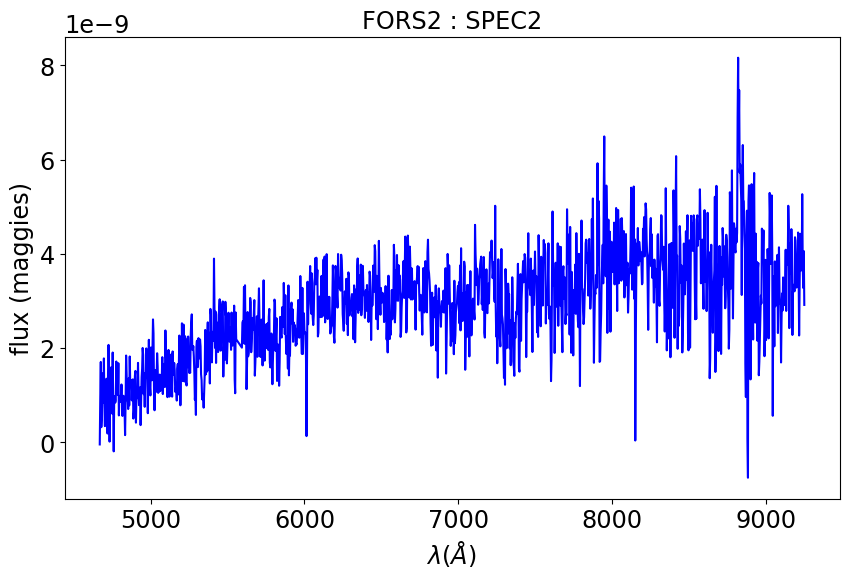

In [19]:
idx=0
fig = plt.figure(figsize=(10,6))
ax=fig.add_subplot(1,1,1)
ax.plot(all_df[idx]["wl"], all_df[idx]["fl"],'b-')
ax.set_xlabel("$\lambda  (\AA)$ ")
title = f"FORS2 : {key_tags[idx]}"
ax.set_title(title)
ax.set_ylabel("flux (maggies)")

# Plots

## Position of SL galaxies vs redshifts

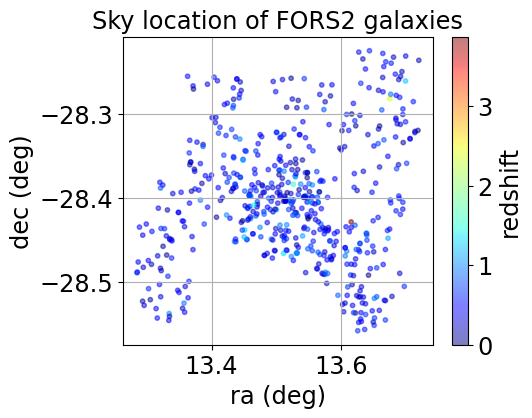

In [20]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)
#im = ax.scatter(all_ra,all_dec,c=all_colors2,s=10,marker="o",alpha=0.5,cmap=jet2)
im = ax.scatter(df_info.ra,df_info.dec,c=df_info.redshift,s=10,marker="o",alpha=0.5,cmap="jet")
ax.grid()
ax.set_xlabel("ra (deg)")
ax.set_ylabel("dec (deg)")
ax.set_title("Sky location of FORS2 galaxies")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('redshift')

## Position vs Redshift

Text(0.5, 0.98, 'redshift')

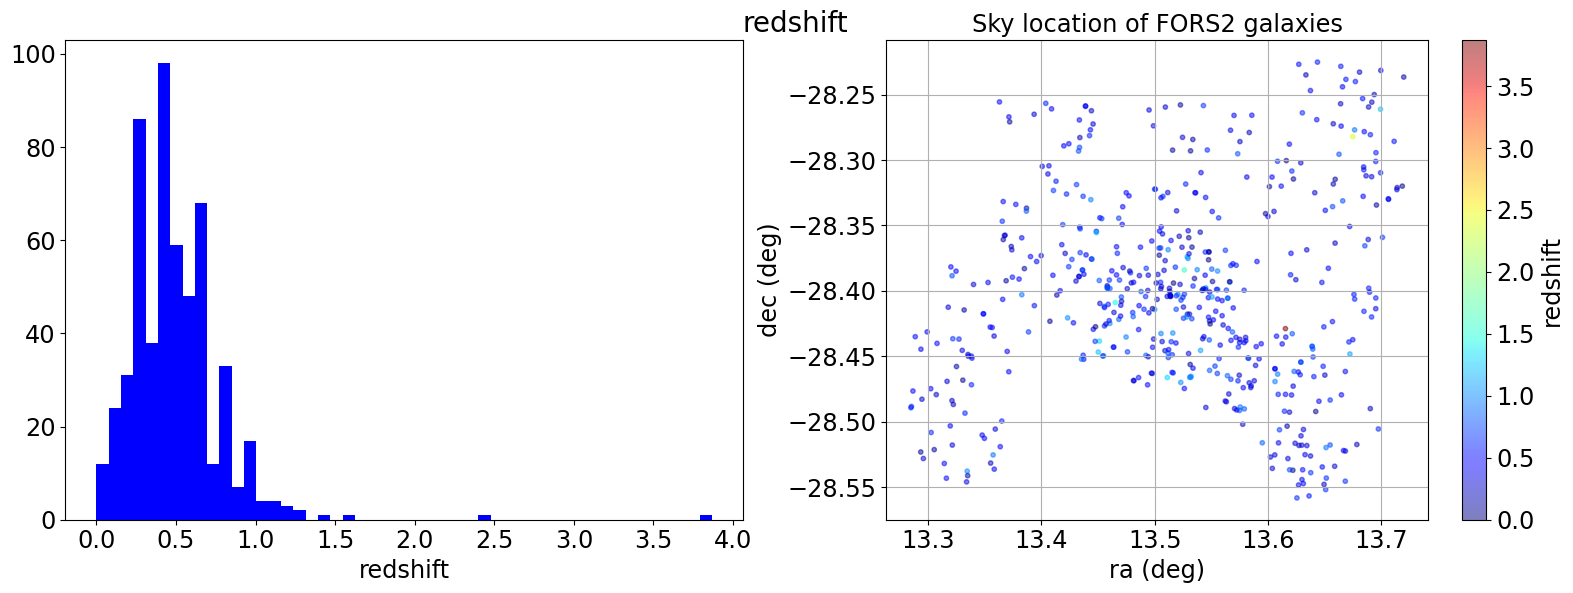

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for idx, ax in enumerate(axes.flatten()):
    if idx == 0:
        ax.hist(df_info.redshift,bins=50,facecolor="b");
        ax.set_xlabel("redshift")
    else:
        im = ax.scatter(df_info.ra,df_info.dec,c=df_info.redshift,s=10,marker="o",alpha=0.5,cmap="jet")
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label('redshift')
        ax.grid()
        ax.set_xlabel("ra (deg)")
        ax.set_ylabel("dec (deg)")
        ax.set_title("Sky location of FORS2 galaxies")
        #fig.colorbar(im, ax=ax)
plt.tight_layout()  
plt.suptitle("redshift",fontsize=20)

In [22]:
index_selected=np.where(df_info.redshift<1)[0]

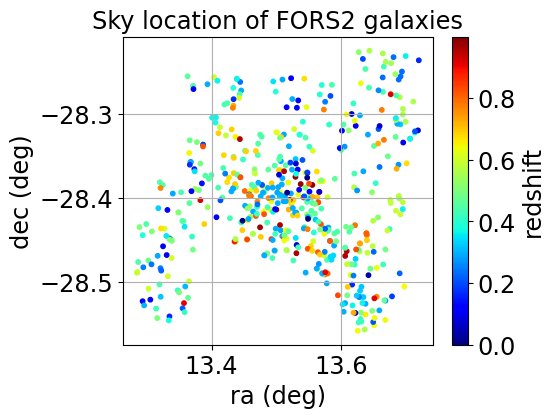

In [23]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)
#im = ax.scatter(all_ra,all_dec,c=all_colors2,s=10,marker="o",alpha=0.5,cmap=jet2)
im = ax.scatter(df_info.ra.iloc[index_selected],df_info.dec.iloc[index_selected],c=df_info.redshift.iloc[index_selected],s=10,marker="o",alpha=1,cmap="jet")
ax.grid()
ax.set_xlabel("ra (deg)")
ax.set_ylabel("dec (deg)")
ax.set_title("Sky location of FORS2 galaxies")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('redshift')

# Plot on celestial maps
https://learn.astropy.org/tutorials/plot-catalog.html

In [24]:
ra_toplot = coordinates.Angle(df_info.ra.iloc[index_selected]*u.degree)
ra_toplot = ra_toplot.wrap_at(180*u.degree)
dec_toplot = coordinates.Angle(df_info.dec.iloc[index_selected]*u.degree)
redshifts_toplot = df_info.redshift.iloc[index_selected]

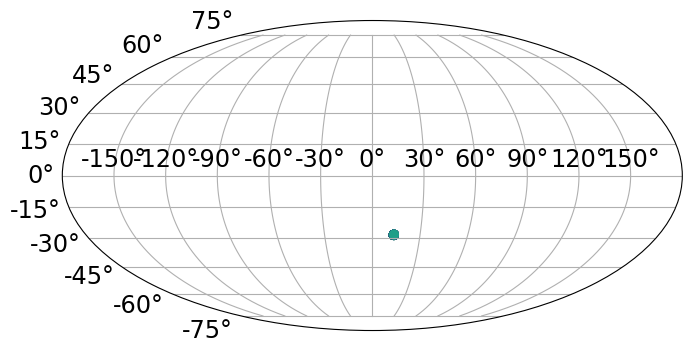

In [25]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ra_toplot.radian, dec_toplot.radian,c=redshifts_toplot)
ax.grid()

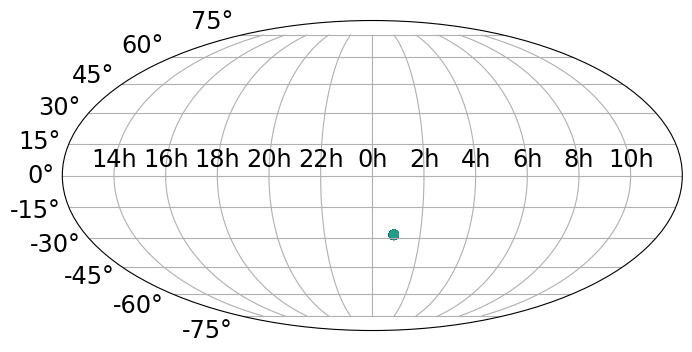

In [26]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ra_toplot.radian, dec_toplot.radian,c=redshifts_toplot)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)

# Position

In [27]:
df_info.describe()

,num,ra,dec,Rmag,redshift,RT,RV,eRV,Nsp
count,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000,5.500000e+02,550.000000,550.000000
mean,421.587273,13.522065,-28.401811,19.889582,0.498955,9.546182,1.359493e+05,91.572727,1.045455
std,199.222145,0.106640,0.074924,5.460220,0.295175,6.732525,9.217559e+04,133.764362,0.262618
min,2.000000,13.284950,-28.558010,0.000000,-0.000600,0.000000,-1.800000e+02,0.000000,1.000000
25%,277.250000,13.450487,-28.451390,20.420000,0.294165,5.325000,8.747250e+04,30.000000,1.000000
50%,433.000000,13.526855,-28.404395,21.190000,0.448555,8.450000,1.316595e+05,59.000000,1.000000
75%,589.750000,13.608923,-28.355698,22.020000,0.632458,13.200000,1.807305e+05,105.750000,1.000000
max,738.000000,13.719840,-28.225270,24.790000,3.869680,46.000000,1.160900e+06,1472.000000,4.000000


In [28]:
ra_angle = Angle(df_info.ra.mean(), u.deg)
dec_angle =  Angle(df_info.dec.mean(), u.deg)
ra_radius_std = Angle(df_info.ra.std(),u.deg)
dec_radius_std = Angle(df_info.dec.std(),u.deg)
ra_radius_minmax = Angle((df_info.ra.max()-df_info.ra.min())/2.,u.deg)
dec_radius_minmax = Angle((df_info.dec.max()-df_info.dec.min())/2.,u.deg)

In [29]:
ra_angle

<Angle 13.52206487 deg>

In [30]:
dec_angle

<Angle -28.40181098 deg>

In [31]:
ra_radius_minmax.arcmin

13.04669999999998

In [32]:
dec_radius_minmax.arcmin

9.982200000000034

## Position of galaxies vs Rmag

Text(0.5, 0.98, 'Rmag')

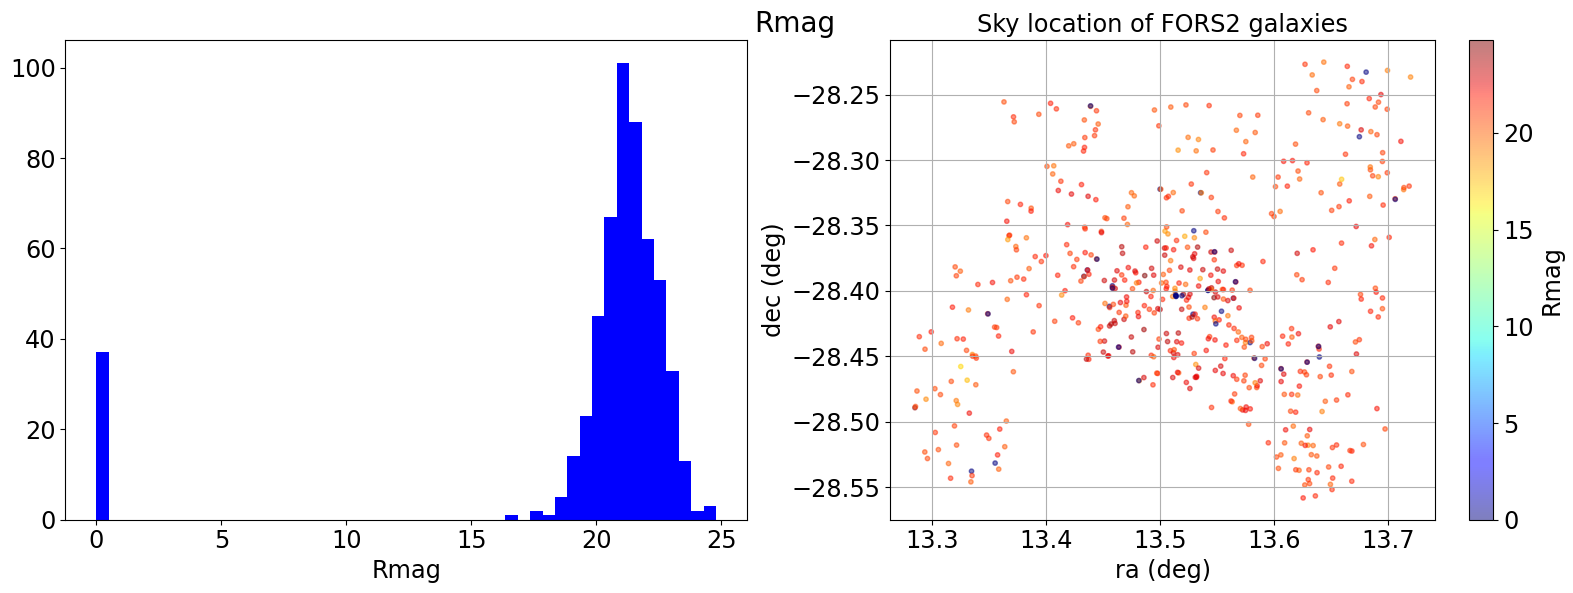

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for idx, ax in enumerate(axes.flatten()):
    if idx == 0:
        ax.hist(df_info.Rmag,bins=50,facecolor="b");
        ax.set_xlabel("Rmag")
    else:
        im = ax.scatter(df_info.ra,df_info.dec,c=df_info.Rmag,s=10,marker="o",alpha=0.5,cmap="jet")
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label('Rmag')
        ax.grid()
        ax.set_xlabel("ra (deg)")
        ax.set_ylabel("dec (deg)")
        ax.set_title("Sky location of FORS2 galaxies")
        #fig.colorbar(im, ax=ax)
plt.tight_layout() 
plt.suptitle("Rmag",fontsize=20)

# In SkyView

In [34]:
SkyView().get_image_list(position='RXJ0054.0-2823',survey=['DSS','GALEX Near UV'])

['https://skyview.gsfc.nasa.gov/tempspace/fits/skv38615792619659_1.fits',
 'https://skyview.gsfc.nasa.gov/tempspace/fits/skv38615792619659_2.fits']

In [35]:
all_img = SkyViewClass().get_images(position='RXJ0054.0-2823',survey=['DSS'],radius=0.5*u.deg)

In [36]:
all_img

[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x146d8c6a0>]]

In [37]:
the_img = all_img[0]

In [38]:
the_img[0].header

SIMPLE  =                    T / Written by SkyView Fri Jun 02 02:57:12 EDT 2023
BITPIX  =                  -32 / 4 byte floating point                          
NAXIS   =                    2 / Two dimensional image                          
NAXIS1  =                  300 / Width of image                                 
NAXIS2  =                  300 / Height of image                                
CRVAL1  =              13.5117 / Reference longitude                            
CRVAL2  =             -28.3994 / Reference latitude                             
RADESYS = 'FK5     '           / Coordinate system                              
EQUINOX =               2000.0 / Epoch of the equinox                           
CTYPE1  = 'RA---TAN'           / Coordinates -- projection                      
CTYPE2  = 'DEC--TAN'           / Coordinates -- projection                      
CRPIX1  =                150.5 / X reference pixel                              
CRPIX2  =                150

In [39]:
wcs = WCS(the_img[0].header)

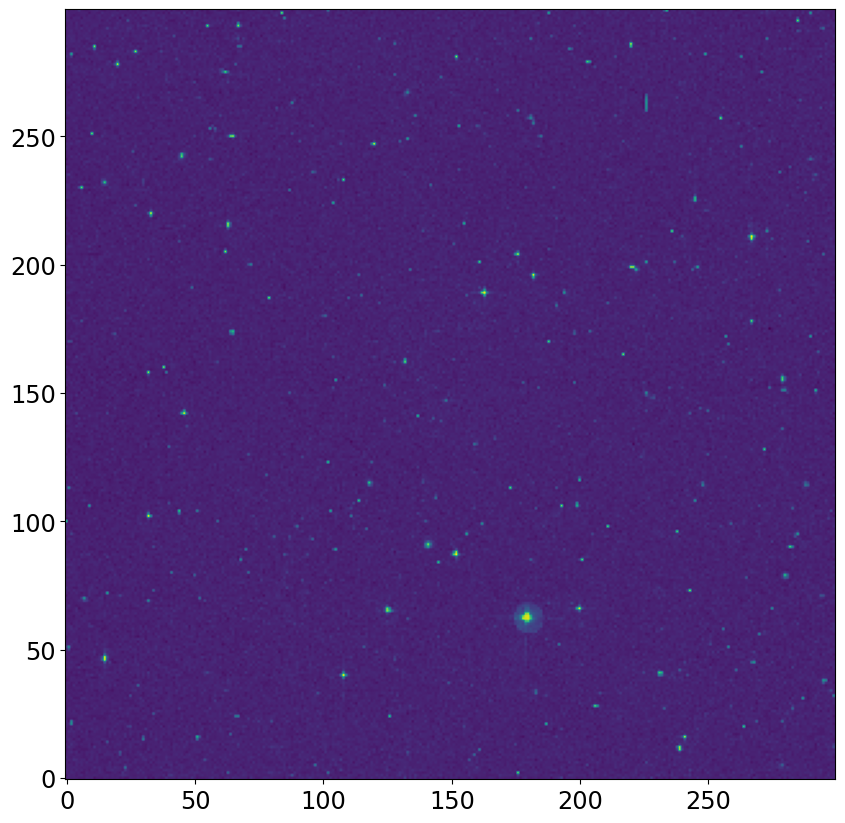

In [40]:
fig = plt.figure(figsize=(10,10))
plt.imshow(the_img[0].data,origin='lower')
plt.show()

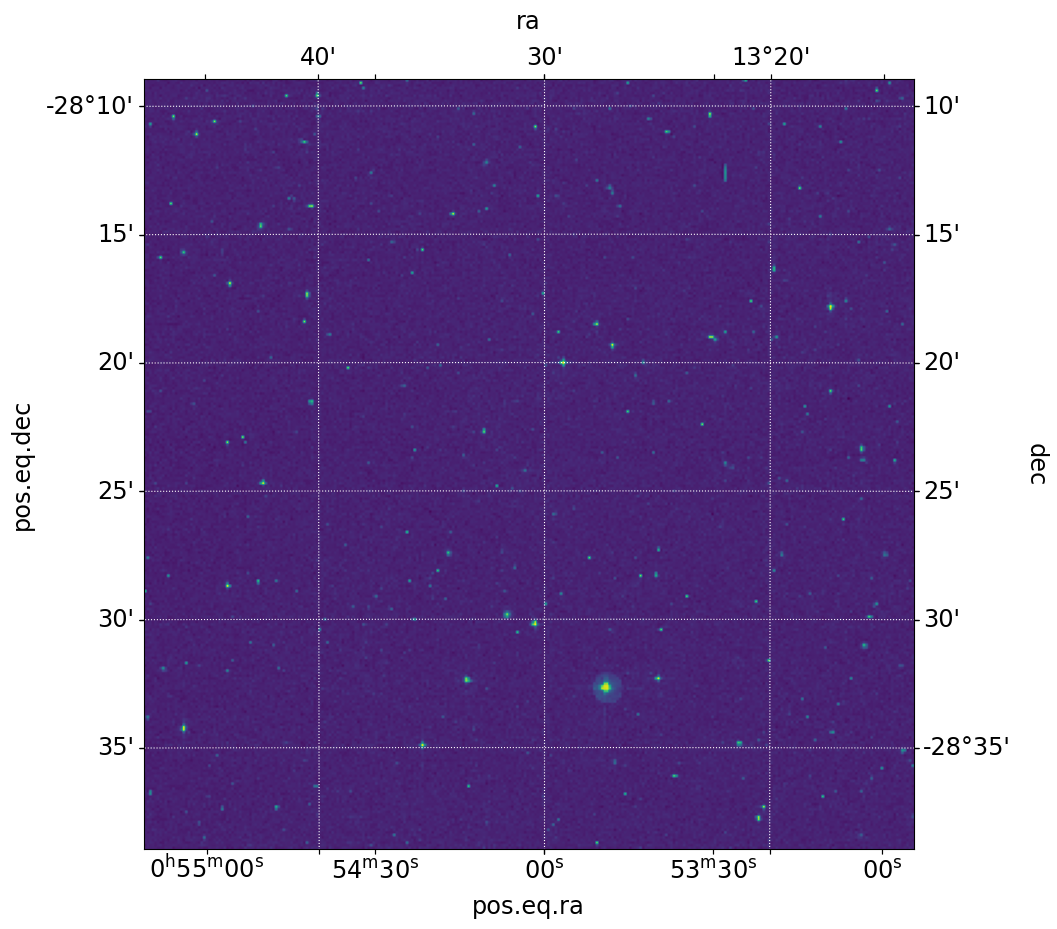

In [41]:
fig=plt.figure(figsize=(10,10))
ax = plt.subplot(projection=wcs)
ax.imshow(the_img[0].data, origin='lower')
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')


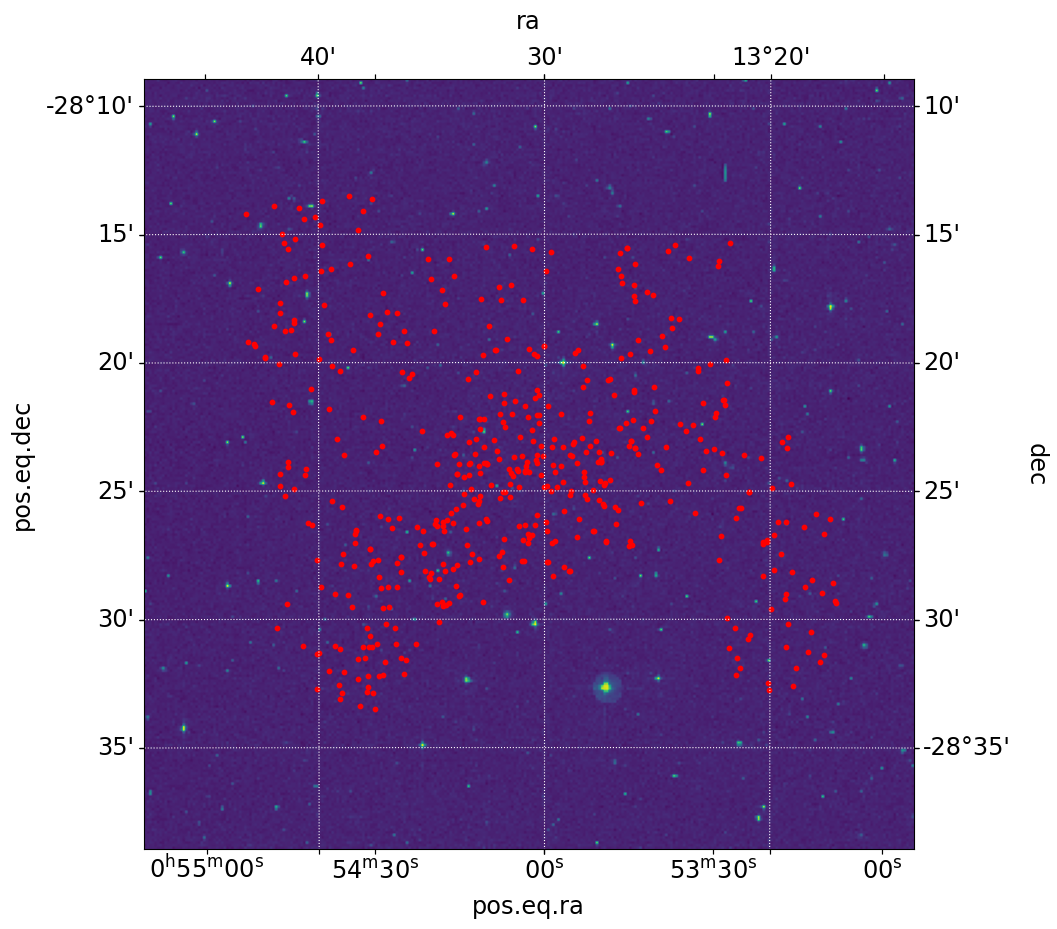

In [42]:
fig=plt.figure(figsize=(10,10))
ax = plt.subplot(projection=wcs)
ax.imshow(the_img[0].data, origin='lower')
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')

ax.scatter(ra_toplot.deg, dec_toplot.deg, transform=ax.get_transform('icrs'),c='r',s=10)


In [43]:
ra_angle

<Angle 13.52206487 deg>

In [44]:
dec_angle

<Angle -28.40181098 deg>

In [45]:
from astroquery.mast import MastMissions

missions = MastMissions()

In [46]:
missions.mission

'hst'

# Surveys
https://astroquery.readthedocs.io/en/latest/skyview/skyview.html

In [47]:
SkyView.list_surveys() 

{'Allbands:GOODS/HDF/CDF': ['GOODS: Chandra ACIS HB',
                            'GOODS: Chandra ACIS FB',
                            'GOODS: Chandra ACIS SB',
                            'GOODS: VLT VIMOS U',
                            'GOODS: VLT VIMOS R',
                            'GOODS: HST ACS B',
                            'GOODS: HST ACS V',
                            'GOODS: HST ACS I',
                            'GOODS: HST ACS Z',
                            'Hawaii HDF U',
                            'Hawaii HDF B',
                            'Hawaii HDF V0201',
                            'Hawaii HDF V0401',
                            'Hawaii HDF R',
                            'Hawaii HDF I',
                            'Hawaii HDF z',
                            'Hawaii HDF HK',
                            'GOODS: HST NICMOS',
                            'GOODS: VLT ISAAC J',
                            'GOODS: VLT ISAAC H',
                            'GOODS: 

# SDSS

https://astroquery.readthedocs.io/en/latest/sdss/sdss.html

In [48]:
coords = coordinates.SkyCoord(df_info.ra.mean(),df_info.dec.mean(), unit="deg")  # defaults to ICRS frame

In [49]:
th1 = (df_info.ra.max()-df_info.ra.min())/2.

In [50]:
th2 = (df_info.dec.max()-df_info.dec.min())/2.

In [51]:
max_radius = Angle(max(th1,th2),u.deg)

In [52]:
max_radius

<Angle 0.217445 deg>

In [53]:
result_spectro = SDSS.query_region(coords,radius = max_radius, spectro=True )
results = SDSS.query_region(coords)

In [54]:
coordinates.SkyCoord('0h8m05.63s +14d50m23.3s')

<SkyCoord (ICRS): (ra, dec) in deg
    (2.02345833, 14.83980556)>

In [55]:
results = SDSS.query_region(coordinates.SkyCoord('0h8m05.63s +14d50m23.3s'),spectro=True)

In [56]:
results

ra,dec,objid,run,rerun,camcol,field,z,plate,mjd,fiberID,specobjid,run2d
float64,float64,int64,int64,int64,int64,int64,float64,int64,int64,int64,int64,int64
2.02344596573482,14.8398237551311,1237652943176138868,1739,301,3,315,0.04559058,751,52251,160,845594848269461504,26


In [57]:
pos = coordinates.SkyCoord('0h8m05.63s +14d50m23.3s', frame='icrs')
xid = SDSS.query_region(pos, radius='5 arcsec', spectro=True)
print(xid)

       ra              dec               objid        run  rerun camcol field     z      plate  mjd  fiberID     specobjid      run2d
---------------- ---------------- ------------------- ---- ----- ------ ----- ---------- ----- ----- ------- ------------------ -----
2.02344596573482 14.8398237551311 1237652943176138868 1739   301      3   315 0.04559058   751 52251     160 845594848269461504    26


In [58]:
redshift = xid['z'][0]
redshift

0.04559058

In [59]:
sp = SDSS.get_spectra(matches=xid)
im = SDSS.get_images(matches=xid, band='g')

`sp[0]` stores all the files related to the spectra for the object of interest. This is actually an array of several HDU in the FITS format 

The spectrum is stored as a table in the second item of the list. That means that we can get the Table doing the following

In [60]:
spectra_data = sp[0][1].data

In [61]:
spectra_data

FITS_rec([(30.596626, 3.5797, 0.06440803, 0,        0, 1.2189666 , 8.154254 , 36.077015),
          (33.245728, 3.5798, 0.        , 0,        0, 1.2187515 , 7.656426 , 34.99724 ),
          (35.89512 , 3.5799, 0.06292833, 0,        0, 1.2185355 , 7.231167 , 35.379208),
          ...,
          (53.27969 , 3.9635, 0.2728394 , 0,        0, 0.64196426, 4.1553526, 50.13611 ),
          (50.236168, 3.9636, 0.2806295 , 0,        0, 0.64184296, 4.2312737, 50.03317 ),
          (51.702717, 3.9637, 0.18243204, 0, 33554432, 0.64171964, 4.3413963, 50.208874)],
         dtype=(numpy.record, [('flux', '>f4'), ('loglam', '>f4'), ('ivar', '>f4'), ('and_mask', '>i4'), ('or_mask', '>i4'), ('wdisp', '>f4'), ('sky', '>f4'), ('model', '>f4')]))

In [62]:
spectra_data.shape

(3841,)

Text(0.5, 1.0, 'SDSS spectra')

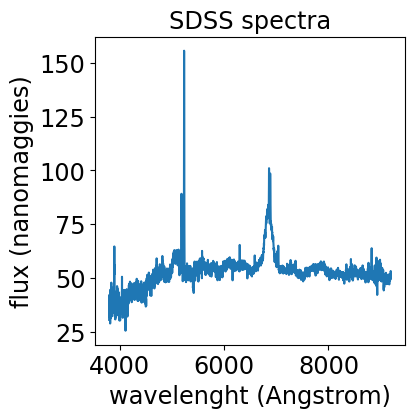

In [63]:
plt.plot(10**spectra_data['loglam'], spectra_data['flux'])
plt.xlabel('wavelenght (Angstrom)')
plt.ylabel('flux (nanomaggies)')
plt.title('SDSS spectra')

In [64]:
lines = sp[0][3].data

In [65]:
lines['LINENAME']

chararray(['Ly_alpha', 'N_V 1240', 'C_IV 1549', 'He_II 1640',
           'C_III] 1908', 'Mg_II 2799', '[O_II] 3725', '[O_II] 3727',
           '[Ne_III] 3868', 'H_epsilon', '[Ne_III] 3970', 'H_delta',
           'H_gamma', '[O_III] 4363', 'He_II 4685', 'H_beta',
           '[O_III] 4959', '[O_III] 5007', 'He_II 5411', '[O_I] 5577',
           '[O_I] 6300', '[S_III] 6312', '[O_I] 6363', '[N_II] 6548',
           'H_alpha', '[N_II] 6583', '[S_II] 6716', '[S_II] 6730',
           '[Ar_III] 7135'], dtype='<U13')

In [66]:
for n in ['[O_II] 3727', '[O_III] 5007', 'H_alpha']:
    print(n, " ->", lines['LINEWAVE'][lines['LINENAME']==n])

[O_II] 3727  -> [3729.875448]
[O_III] 5007  -> [5008.23963773]
H_alpha  -> [6564.61389433]


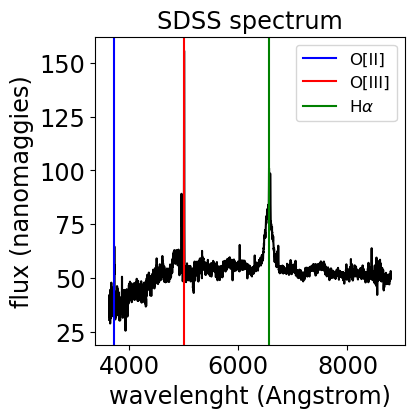

In [67]:
plt.plot(10**spectra_data['loglam']/(1+redshift), spectra_data['flux'], color='black')
plt.axvline(x=lines['LINEWAVE'][lines['LINENAME']=='[O_II] 3727'], label=r'O[II]', color='blue')
plt.axvline(x=lines['LINEWAVE'][lines['LINENAME']=='[O_III] 5007'], label=r'O[III]', color='red')
plt.axvline(x=lines['LINEWAVE'][lines['LINENAME']=='H_alpha'], label=r'H$\alpha$', color='green')

plt.xlabel('wavelenght (Angstrom)')
plt.ylabel('flux (nanomaggies)')
plt.title('SDSS spectrum')
plt.legend()

In [68]:
sp[0].info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     139   ()      
  1  COADD         1 BinTableHDU     26   3841R x 8C   ['E', 'E', 'E', 'J', 'J', 'E', 'E', 'E']   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   ['J', 'J', 'J', '13A', 'D', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'J', 'J', 'E', 'E']   
  4  B1-00012103-00012101-00012102    1 BinTableHDU    146   2044R x 7C   [E, E, E, J, E, 

In [69]:
sp[0][2].data

FITS_rec([('sdss', 'SDSS', 'chunk24', 'legacy', 'dr2001.10.1', 'good', 18.0661, 0., 5000., -1, 0., -9999., -1, 1, 1, 0, 0, 0, 0, 0, '    845594848269461504', '1237652943176138868', '1237652943176138868', '         7470579384473', '845550867804350464', 1, 'dr7', '26', '', -1, 0.96604282, 0.03413061, 0.2561179, 113.21073, -28.737019, 'GALAXY', 'SCIENCE', 6240, 0, 6240, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 751, 515, 52251, 160, [1739,    0,    3,  315,  153], 2.0234369, 14.839836, 'QSO', 'BROADLINE', 0.04559058, 3.6422865e-05, 3.6396828, 3751, 1.5546794, 'spEigenQSO-53724.fits', [ 0,  1,  2,  3, -1, -1, -1, -1, -1, -1], 3, [ 2.1908362e-03,  3.4339433e-03, -6.1753937e-03,  8.5440716e-03, -5.8567975e+02,  1.4279556e+03, -8.0151349e+02,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00], 0., 0., 0., 0., 0., 0., 0, 3799.2686, 9198.14, 0.3758, 0, 31.981264, [10.666473, 26.243982, 39.083405, 39.87929 , 30.720493], 1.5515354, [0.51277274, 0.21740288, 0.0811602 , 0.03698776, 0.01995743, 0.01224

In [70]:
xid = SDSS.query_region(pos, radius='5 arcmin', spectro=True)

/Users/dagoret/anaconda3/lib/python3.9/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


In [71]:
print(xid)

       ra              dec               objid        run  rerun camcol field      z       plate  mjd  fiberID      specobjid       run2d 
---------------- ---------------- ------------------- ---- ----- ------ ----- ------------ ----- ----- ------- ------------------- -------
2.02276620724587 14.8881787574371 1237652943176139008 1739   301      3   315   0.04506683   752 52251     311  846762254740252672      26
2.03328551497378 14.7810481138112 1237652943176139448 1739   301      3   315     3.018874  6177 56268     984 6954954309587935232 v5_10_0
2.09108576486022 14.8055580359542 1237652943176204413 1739   301      3   316    0.1430516   752 52251     301  846759505961183232      26
2.07666156579126 14.8434552919226 1237652943176204410 1739   301      3   316 -0.000500346  6112 56191     560 6881654266118774784 v5_10_0
2.01642429865501 14.8109891204103 1237652943176139005 1739   301      3   315    0.1135348   752 52251     302  846759780839090176      26
1.95947794572834 14.7610869

In [72]:
sp = SDSS.get_spectra(matches=xid)

In [73]:
sp[2]

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x146ab25e0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x146766b80>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x1468f7c70>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x1468daa90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x146731730>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x1467e93a0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x1467d8fd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x14691ebe0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x146935850>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x146948460>]